<a href="https://colab.research.google.com/github/Willgnner-Santos/LLM_PortugueseLegalDocClassifier/blob/main/meta-llama-Meta-Llama-3.1-70B-Instruct-Turbo/Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Configuração Inicial e Definição de Funções**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tiktoken langchain-community langchainhub langchain_openai langchain

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

import pandas as pd
import tiktoken
import re
import unicodedata
import random
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Configuração da API e do modelo
api_key = ''

llm = ChatOpenAI(
                api_key= api_key,
                base_url="https://api.together.xyz/v1",
                model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
                max_tokens=100,
                temperature=0.1,
                verbose=True
                )

def get_label(result):
    return result.content

# Função para normalizar texto
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Função para remover acentos
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

# Função para limpar e normalizar a categoria
def clean_category(category):
    category = re.sub(r'[^a-zA-Z0-9\-]', '', category)
    category = re.sub(r'\s+', '-', category).strip()
    return category.upper()

# Função para encontrar a melhor correspondência
def get_best_match(result, valid_labels):
    result = clean_category(result)
    result = remove_accents(result).strip().upper()

    best_match = None
    best_score = -1

    for label in valid_labels:
        cleaned_label = clean_category(remove_accents(label.strip().upper()))
        if result == cleaned_label:
            return label  # Retorna a correspondência exata imediatamente
        score = len(set(result) & set(cleaned_label)) / len(set(result) | set(cleaned_label))  # Similaridade de Jaccard
        if score > best_score:
            best_score = score
            best_match = label

    return best_match

# Configuração do prompt para classificação
PROMPT_CLASSIFICACAO = (
    "Classifique as petições processuais abaixo em uma das seguintes categorias: "
    "AGRAVO, CONTRARRAZOES-AO-AGRAVO, EMBARGOS, EXTINCAO-DE-PUNIBILIDADE, "
    "HABEAS-CORPUS, IMPUGNACAO, INDULTO-COMUTACAO, INTIMACAO-NEGATIVA, "
    "LIVRAMENTO-CONDICIONAL, OFICIOS, PROGRESSAO-DE-REGIME, REMICAO-DE-PENA, "
    "TRANSFERENCIA-DE-EXECUCAO, UNIFICACAO-DE-PENAS, APELACAO, REGISTRO-CIVIL, "
    "CUMPRIMENTO-DE-SETENCA, INDENIZATORIAS, EXCECAO-DE-PRE-EXECUTIVIDADE, "
    "DISSOLUCAO-DE-CONDOMINIO, CONSIGNACAO-EM-PAGAMENTO, ALVARA-JUDICIAL-LIBERACAO-DE-CORPO, "
    "SAIDA-TEMPORARIA, USUCAPIAO. "
    "Retorne apenas a categoria e nada mais. "
    "Texto: {texto} "
    "Categoria:"
)

# Configuração do prompt para resumo
PROMPT_RESUMO = (
    "Resuma a petição abaixo em 200 palavras, focando na ideia geral do texto. Ignore detalhes específicos como nomes, números e locais "
    "que não definem o conceito central. A classificação deve ser entre as seguintes categorias: AGRAVO, CONTRARRAZOES-AO-AGRAVO, EMBARGOS, EXTINCAO-DE-PUNIBILIDADE, "
    "HABEAS-CORPUS, IMPUGNACAO, INDULTO-COMUTACAO, INTIMACAO-NEGATIVA, LIVRAMENTO-CONDICIONAL, OFICIOS, PROGRESSAO-DE-REGIME, REMICAO-DE-PENA, "
    "TRANSFERENCIA-DE-EXECUCAO, UNIFICACAO-DE-PENAS, APELACAO, REGISTRO-CIVIL, CUMPRIMENTO-DE-SETENCA, INDENIZATORIAS, EXCECAO-DE-PRE-EXECUTIVIDADE, "
    "DISSOLUCAO-DE-CONDOMINIO, CONSIGNACAO-EM-PAGAMENTO, ALVARA-JUDICIAL-LIBERACAO-DE-CORPO, SAIDA-TEMPORARIA, USUCAPIAO. "
    "Escreva o resumo em português e retorne apenas o resumo explicativo. "
    "----------------------\n"
    "Petição de {classe}: {texto}\n"
    "Resumo Explicativo:"
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Carregamento e Preprocessamento dos Textos**

In [ ]:
# Carregar o dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/Dados DPE-GO/conjunto_avaliação - conjunto_avaliação.csv')

# Contagem de tokens usando tiktoken
enc = tiktoken.get_encoding("cl100k_base")
def count_tokens(text):
    return len(enc.encode(text))

# Adicionar coluna com a contagem de tokens
df['token_count'] = df['facts'].apply(count_tokens)

# Exibir o número total de textos no dataset original
total_texts = len(df)
print(f'Total de textos no dataset original: {total_texts}')

# Filtrar textos com menos de 30000 tokens
filtered_df = df[df['token_count'] < 30000].drop(columns=['token_count'])

# Exibir o número de textos filtrados no terminal
total_filtered_texts = len(filtered_df)
print(f'Total de textos filtrados com menos de 30000 tokens: {total_filtered_texts}')

Total de textos no dataset original: 835
Total de textos filtrados com menos de 30000 tokens: 835


**Geração dos Resumos Direto dos Textos Originais**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import tiktoken
import matplotlib.pyplot as plt

# Vetorização com TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['facts'])

# Extraindo os rótulos únicos
labels = df['issue_area'].unique()
selected_examples = []

# Calculando os centróides para cada rótulo
for label in labels:
    indices = df['issue_area'] == label
    cluster_vectors = X[indices]
    cluster_texts = df['facts'][indices]

    # Calculando o vetor centróide
    centroid_vector = cluster_vectors.mean(axis=0)
    centroid_vector = np.asarray(centroid_vector).flatten()

    # Calculando as distâncias e encontrando o texto mais próximo do centróide
    distances = cosine_distances(cluster_vectors, centroid_vector.reshape(1, -1))
    closest_index = np.argmin(distances)
    centroid_text = cluster_texts.iloc[closest_index]

    # Armazenando o exemplo mais próximo ao centróide
    example = df[df['facts'] == centroid_text].iloc[0]
    selected_examples.append(example)

# Convertendo para DataFrame para processar
selected_df = pd.DataFrame(selected_examples)

# Geração dos resumos a partir dos textos selecionados para cada categoria
prompt_template_resumo = PromptTemplate(
    input_variables=["texto", "classe"],
    template=PROMPT_RESUMO,
)

chain_resumo = prompt_template_resumo | llm | get_label

resumos = []
for index, row in selected_df.iterrows():
    resumo = chain_resumo.invoke({'texto': row['facts'], 'classe': row['issue_area']})
    resumos.append({'issue_area': row['issue_area'], 'resumo_text': resumo})
    print(f"\nResumo gerado para a categoria {row['issue_area']} (Petição {index + 1} de {len(selected_df)}):\n{resumo}\n")

# Converter os resumos para DataFrame
resumos_df = pd.DataFrame(resumos)

# Adicionar a contagem de tokens para os resumos
resumos_df['token_count'] = resumos_df['resumo_text'].apply(count_tokens)

# Salvar os resumos em CSV e Excel
csv_save_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/meta-llama Meta-Llama-3.1-70B-Instruct-Turbo/Classificação usando Resumos/Textos-resumos/resumos_categorias.csv'
excel_save_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/meta-llama Meta-Llama-3.1-70B-Instruct-Turbo/Classificação usando Resumos/Textos-resumos/resumos_categorias.xlsx'

resumos_df.to_csv(csv_save_path, index=False)
resumos_df.to_excel(excel_save_path, index=False)

print(f"Resumos e categorias salvos em:\nCSV: {csv_save_path}\nXLSX: {excel_save_path}")


Resumo gerado para a categoria EXTINCAO-DE-PUNIBILIDADE (Petição 38 de 24):
O réu foi condenado a uma pena privativa de liberdade, que foi substituída por uma pena restritiva de direitos. A defesa alega que ocorreu a prescrição da pena, pois o prazo para o início do cumprimento da pena expirou. A defesa pede que seja declarada a extinção da punibilidade do réu devido à prescrição da pena.


Resumo gerado para a categoria AGRAVO (Petição 105 de 24):
A petição é um Agravo de Execução Penal, que é um recurso utilizado para questionar decisões proferidas em processos de execução penal. O agravante, representado pela Defensoria Pública, busca reformar a decisão que indeferiu o pedido de comutação da pena, alegando que a decisão foi proferida sem a devida intimação pessoal da Defensoria Pública, o que caracteriza cerce


Resumo gerado para a categoria IMPUGNACAO (Petição 253 de 24):
A petição apresentada é uma impugnação ao cumprimento de sentença, na qual o defensor público do estado de Go

**Histograma e Número de Tokens**

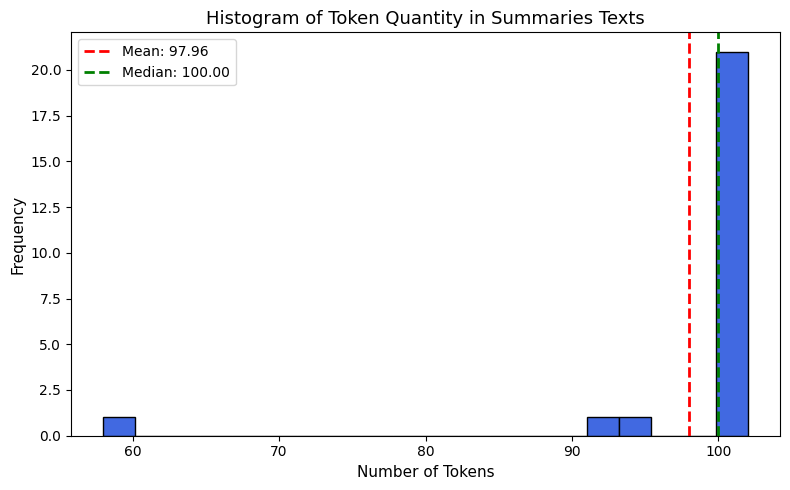

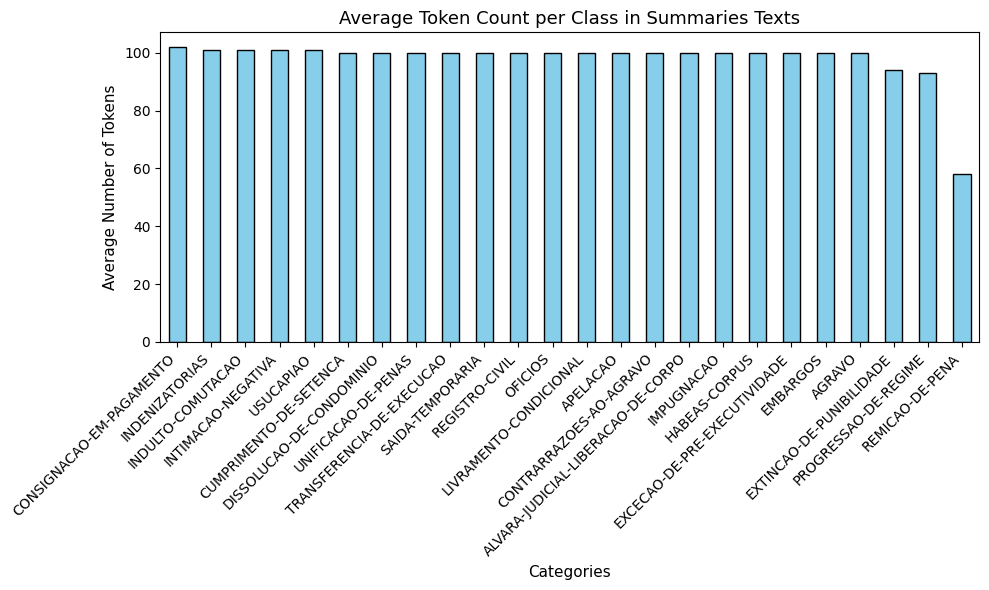

                                   token_count                           \
                                         count   mean std    min    25%   
issue_area                                                                
AGRAVO                                     1.0  100.0 NaN  100.0  100.0   
ALVARA-JUDICIAL-LIBERACAO-DE-CORPO         1.0  100.0 NaN  100.0  100.0   
APELACAO                                   1.0  100.0 NaN  100.0  100.0   
CONSIGNACAO-EM-PAGAMENTO                   1.0  102.0 NaN  102.0  102.0   
CONTRARRAZOES-AO-AGRAVO                    1.0  100.0 NaN  100.0  100.0   
CUMPRIMENTO-DE-SETENCA                     1.0  100.0 NaN  100.0  100.0   
DISSOLUCAO-DE-CONDOMINIO                   1.0  100.0 NaN  100.0  100.0   
EMBARGOS                                   1.0  100.0 NaN  100.0  100.0   
EXCECAO-DE-PRE-EXECUTIVIDADE               1.0  100.0 NaN  100.0  100.0   
EXTINCAO-DE-PUNIBILIDADE                   1.0   94.0 NaN   94.0   94.0   
HABEAS-CORPUS            

In [ ]:
import matplotlib.pyplot as plt
import tiktoken

# Function to count tokens using tiktoken
enc = tiktoken.get_encoding("cl100k_base")
def count_tokens(text):
    return len(enc.encode(text))

# Add a column with the token count for the summaries
resumos_df['token_count'] = resumos_df['resumo_text'].apply(count_tokens)

# Graph 1: General Token Distribution
plt.figure(figsize=(8, 5))  # Adjusted figure size
plt.hist(resumos_df['token_count'], bins=20, edgecolor='black', color='royalblue')
mean_value = resumos_df['token_count'].mean()
median_value = resumos_df['token_count'].median()
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}')
plt.xlabel('Number of Tokens', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Histogram of Token Quantity in Summaries Texts', fontsize=13)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Graph 2: Average Token Count per Class (Ordered from Highest to Lowest)
mean_tokens_per_class = resumos_df.groupby('issue_area')['token_count'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Adjusted figure size
mean_tokens_per_class.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Categories', fontsize=11)
plt.ylabel('Average Number of Tokens', fontsize=11)
plt.title('Average Token Count per Class in Summaries Texts', fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Display the table with token counts per class
token_counts_by_class = resumos_df[['issue_area', 'token_count']].groupby('issue_area').describe().sort_index()
print(token_counts_by_class)

**Classificação Usando os Resumos**

In [ ]:
# Carregar os novos textos para classificação
file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/Dados DPE-GO/conjunto_classificacao - conjunto_classificacao.csv'
evaluation_df = pd.read_csv(file_path)

# Embaralhar os dados para classificação aleatória
evaluation_df = evaluation_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Inicializar variáveis para rastreamento das métricas
y_true = []
y_pred = []

# Variáveis para rastrear a acurácia
correct_count = 0
total_count = 0

# Lista para armazenar os resultados
results = []

# Lista de rótulos válidos
valid_labels = filtered_df['issue_area'].unique().tolist()

# Preparar o modelo para classificação com resumos
prompt_template_classificacao = PromptTemplate(
    input_variables=["texto"],
    template=PROMPT_CLASSIFICACAO,
)

chain_classificacao = prompt_template_classificacao | llm | get_label

# Classificação usando resumos dos textos originais
for index, row in evaluation_df.iterrows():
    # Obter o texto resumo correspondente à classe
    resumo_text = resumos_df[resumos_df['issue_area'] == row['issue_area']]['resumo_text'].values[0]

    # Realizar a classificação usando o LLM
    result = chain_classificacao.invoke({'texto': resumo_text}).strip()

    # Normalizar textos para comparação e remover acentos
    normalized_label = clean_category(remove_accents(row['issue_area'].strip().upper()))
    normalized_result = get_best_match(result, valid_labels)

    # Verificar se a previsão é correta
    is_correct = normalized_label == clean_category(remove_accents(normalized_result.strip().upper()))

    # Imprimir o resultado retornado e a etiqueta esperada para depuração
    print(f'Real: {row["issue_area"]}, Previsto: {normalized_result}, Correto: {is_correct}')

    y_true.append(normalized_label)
    y_pred.append(clean_category(remove_accents(normalized_result.strip().upper())))

    total_count += 1
    if is_correct:
        correct_count += 1

    # Calcular métricas intermediárias
    intermediate_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    intermediate_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    intermediate_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Exibir métricas intermediárias
    print(f'Progresso: {index + 1}/{len(evaluation_df)}')
    print(f'Acurácia até agora: {correct_count / total_count * 100:.2f}%')
    print(f'Precisão até agora: {intermediate_precision * 100:.2f}%')
    print(f'Recall até agora: {intermediate_recall * 100:.2f}%')
    print(f'F1-score até agora: {intermediate_f1 * 100:.2f}%')
    print()  # Adiciona uma linha em branco

    # Armazenar os resultados na lista
    results.append({
        'Real': row['issue_area'],
        'Previsto': normalized_result,
        'Correto': is_correct
    })

A saída de streaming foi truncada nas últimas 5000 linhas.
F1-score até agora: 99.95%

Real: LIVRAMENTO-CONDICIONAL, Previsto: LIVRAMENTO-CONDICIONAL, Correto: True
Progresso: 1910/2623
Acurácia até agora: 99.95%
Precisão até agora: 99.95%
Recall até agora: 99.95%
F1-score até agora: 99.95%

Real: EXTINCAO-DE-PUNIBILIDADE, Previsto: EXTINCAO-DE-PUNIBILIDADE, Correto: True
Progresso: 1911/2623
Acurácia até agora: 99.95%
Precisão até agora: 99.95%
Recall até agora: 99.95%
F1-score até agora: 99.95%

Real: AGRAVO, Previsto: AGRAVO, Correto: True
Progresso: 1912/2623
Acurácia até agora: 99.95%
Precisão até agora: 99.95%
Recall até agora: 99.95%
F1-score até agora: 99.95%

Real: EXTINCAO-DE-PUNIBILIDADE, Previsto: EXTINCAO-DE-PUNIBILIDADE, Correto: True
Progresso: 1913/2623
Acurácia até agora: 99.95%
Precisão até agora: 99.95%
Recall até agora: 99.95%
F1-score até agora: 99.95%

Real: APELACAO, Previsto: APELACAO, Correto: True
Progresso: 1914/2623
Acurácia até agora: 99.95%
Precisão até ag

**Salvar Resultados da Classificação e Métricas de Avaliação**

In [ ]:
# Calcular métricas finais
final_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
final_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
final_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f'Acurácia final: {correct_count / total_count * 100:.2f}%')
print(f'Precisão final: {final_precision * 100:.2f}%')
print(f'Recall final: {final_recall * 100:.2f}%')
print(f'F1-score final: {final_f1 * 100:.2f}%')

# Ajustar a lista de rótulos
unique_labels = list(set(y_true + y_pred))
unique_labels.sort()  # Garantir que os rótulos estejam ordenados

# Gerar relatório de classificação
classification_report_str = classification_report(y_true, y_pred, labels=unique_labels)
print(classification_report_str)

# Salvar relatório de classificação em arquivos CSV e Excel
report_dict = classification_report(y_true, y_pred, labels=unique_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

report_csv_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/meta-llama Meta-Llama-3.1-70B-Instruct-Turbo/Classificação usando Resumos/Classificações/classification_report_centroids.csv'
report_excel_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/meta-llama Meta-Llama-3.1-70B-Instruct-Turbo/Classificação usando Resumos/Classificações/classification_report_centroids.xlsx'

report_df.to_csv(report_csv_path, index=True)
report_df.to_excel(report_excel_path, index=True)

print(f'Relatório de classificação salvo em {report_csv_path} e {report_excel_path}')

# Criar um DataFrame a partir dos resultados
results_df = pd.DataFrame(results)

# Salvar os resultados em arquivos CSV e Excel
csv_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/meta-llama Meta-Llama-3.1-70B-Instruct-Turbo/Classificação usando Resumos/Classificações/classificacoes_centroids.csv'
excel_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/meta-llama Meta-Llama-3.1-70B-Instruct-Turbo/Classificação usando Resumos/Classificações/classificacoes_centroids.xlsx'

results_df.to_csv(csv_path, index=False)
results_df.to_excel(excel_path, index=False)

print(f'Resultados salvos em {csv_path} e {excel_path}')

Acurácia final: 99.92%
Precisão final: 99.92%
Recall final: 99.92%
F1-score final: 99.92%
                                    precision    recall  f1-score   support

                            AGRAVO       0.99      1.00      1.00       351
ALVARA-JUDICIAL-LIBERACAO-DE-CORPO       1.00      1.00      1.00         2
                          APELACAO       1.00      1.00      1.00       231
          CONSIGNACAO-EM-PAGAMENTO       1.00      1.00      1.00         6
           CONTRARRAZOES-AO-AGRAVO       1.00      1.00      1.00         5
            CUMPRIMENTO-DE-SETENCA       1.00      1.00      1.00       115
          DISSOLUCAO-DE-CONDOMINIO       1.00      1.00      1.00        11
                          EMBARGOS       1.00      1.00      1.00       234
      EXCECAO-DE-PRE-EXECUTIVIDADE       1.00      1.00      1.00        61
          EXTINCAO-DE-PUNIBILIDADE       1.00      1.00      1.00       400
                     HABEAS-CORPUS       1.00      0.85      0.92        

**Classificação Real e Prevista - Gráfico**

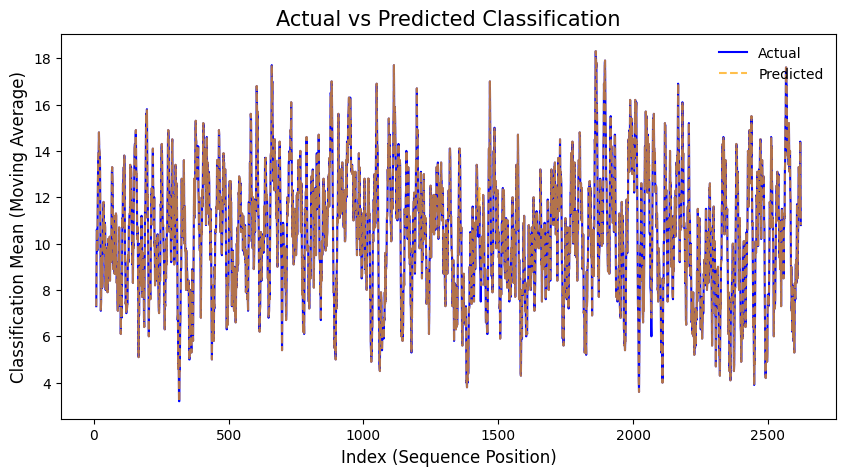

Total Accuracy: 99.92%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert categories to numbers
label_mapping = {label: idx for idx, label in enumerate(set(y_true + y_pred))}
numeric_labels_true = [label_mapping[label] for label in y_true]
numeric_labels_pred = [label_mapping[label] for label in y_pred]

df_comparison = pd.DataFrame({'Actual': numeric_labels_true, 'Predicted': numeric_labels_pred})

# Calculate accuracy
accuracy = (df_comparison['Actual'] == df_comparison['Predicted']).mean()

# Calculate moving average to smooth curves
df_comparison['Actual_Smooth'] = df_comparison['Actual'].rolling(window=10).mean()
df_comparison['Predicted_Smooth'] = df_comparison['Predicted'].rolling(window=10).mean()

# Create line plot
plt.figure(figsize=(10, 5))  # Adjusted plot size
plt.plot(df_comparison.index, df_comparison['Actual_Smooth'], label='Actual', linestyle='-', color='blue')
plt.plot(df_comparison.index, df_comparison['Predicted_Smooth'], label='Predicted', linestyle='--', color='orange', alpha=0.7)
plt.xlabel('Index (Sequence Position)', fontsize=12)  # X-axis representing sequence position
plt.ylabel('Classification Mean (Moving Average)', fontsize=12)  # Y-axis representing moving average of classifications
plt.title('Actual vs Predicted Classification', fontsize=15)
plt.legend(loc='upper right', fontsize=10, frameon=False)  # Reduce legend font size and remove frame
plt.show()

# Display accuracy
print(f'Total Accuracy: {accuracy:.2%}')

**Mapear Categorias**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificar os rótulos de string para valores numéricos
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

# Verificar o mapeamento
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'AGRAVO': 0, 'ALVARA-JUDICIAL-LIBERACAO-DE-CORPO': 1, 'APELACAO': 2, 'CONSIGNACAO-EM-PAGAMENTO': 3, 'CONTRARRAZOES-AO-AGRAVO': 4, 'CUMPRIMENTO-DE-SETENCA': 5, 'DISSOLUCAO-DE-CONDOMINIO': 6, 'EMBARGOS': 7, 'EXCECAO-DE-PRE-EXECUTIVIDADE': 8, 'EXTINCAO-DE-PUNIBILIDADE': 9, 'HABEAS-CORPUS': 10, 'IMPUGNACAO': 11, 'INDENIZATORIAS': 12, 'INDULTO-COMUTACAO': 13, 'INTIMACAO-NEGATIVA': 14, 'LIVRAMENTO-CONDICIONAL': 15, 'OFICIOS': 16, 'PROGRESSAO-DE-REGIME': 17, 'REGISTRO-CIVIL': 18, 'REMICAO-DE-PENA': 19, 'SAIDA-TEMPORARIA': 20, 'TRANSFERENCIA-DE-EXECUCAO': 21, 'UNIFICACAO-DE-PENAS': 22, 'USUCAPIAO': 23}


**AUC-ROC**

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarizar os rótulos para o cálculo do AUC-ROC
y_true_binarized = label_binarize(y_true, classes=unique_labels)
y_pred_binarized = label_binarize(y_pred, classes=unique_labels)

# Calcular o AUC-ROC para cada classe
roc_auc_scores = {}
for i, label in enumerate(unique_labels):
    roc_auc_scores[label] = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])

# Calcular a média do AUC-ROC
average_auc_roc = sum(roc_auc_scores.values()) / len(roc_auc_scores)

# Imprimir as pontuações AUC-ROC
print("Pontuações AUC-ROC por classe:")
for label, score in roc_auc_scores.items():
    print(f"{label}: {score:.2f}")

print(f"Média AUC-ROC: {average_auc_roc:.2f}")

Pontuações AUC-ROC por classe:
AGRAVO: 1.00
ALVARA-JUDICIAL-LIBERACAO-DE-CORPO: 1.00
APELACAO: 1.00
CONSIGNACAO-EM-PAGAMENTO: 1.00
CONTRARRAZOES-AO-AGRAVO: 1.00
CUMPRIMENTO-DE-SETENCA: 1.00
DISSOLUCAO-DE-CONDOMINIO: 1.00
EMBARGOS: 1.00
EXCECAO-DE-PRE-EXECUTIVIDADE: 1.00
EXTINCAO-DE-PUNIBILIDADE: 1.00
HABEAS-CORPUS: 0.92
IMPUGNACAO: 1.00
INDENIZATORIAS: 1.00
INDULTO-COMUTACAO: 1.00
INTIMACAO-NEGATIVA: 1.00
LIVRAMENTO-CONDICIONAL: 1.00
OFICIOS: 1.00
PROGRESSAO-DE-REGIME: 1.00
REGISTRO-CIVIL: 1.00
REMICAO-DE-PENA: 1.00
SAIDA-TEMPORARIA: 1.00
TRANSFERENCIA-DE-EXECUCAO: 1.00
UNIFICACAO-DE-PENAS: 1.00
USUCAPIAO: 1.00
Média AUC-ROC: 1.00


**AUC-PR**

In [ ]:
from sklearn.metrics import average_precision_score

# Calcular o AUC-PR para cada classe
pr_auc_scores = {}
for i, label in enumerate(unique_labels):
    pr_auc_scores[label] = average_precision_score(y_true_binarized[:, i], y_pred_binarized[:, i])

# Calcular a média do AUC-PR
average_auc_pr = sum(pr_auc_scores.values()) / len(pr_auc_scores)

# Imprimir as pontuações AUC-PR
print("Pontuações AUC-PR por classe:")
for label, score in pr_auc_scores.items():
    print(f"{label}: {score:.2f}")

print(f"Média AUC-PR: {average_auc_pr:.2f}")

Pontuações AUC-PR por classe:
AGRAVO: 0.99
ALVARA-JUDICIAL-LIBERACAO-DE-CORPO: 1.00
APELACAO: 1.00
CONSIGNACAO-EM-PAGAMENTO: 1.00
CONTRARRAZOES-AO-AGRAVO: 1.00
CUMPRIMENTO-DE-SETENCA: 1.00
DISSOLUCAO-DE-CONDOMINIO: 1.00
EMBARGOS: 1.00
EXCECAO-DE-PRE-EXECUTIVIDADE: 1.00
EXTINCAO-DE-PUNIBILIDADE: 1.00
HABEAS-CORPUS: 0.85
IMPUGNACAO: 1.00
INDENIZATORIAS: 1.00
INDULTO-COMUTACAO: 1.00
INTIMACAO-NEGATIVA: 1.00
LIVRAMENTO-CONDICIONAL: 1.00
OFICIOS: 1.00
PROGRESSAO-DE-REGIME: 1.00
REGISTRO-CIVIL: 1.00
REMICAO-DE-PENA: 1.00
SAIDA-TEMPORARIA: 1.00
TRANSFERENCIA-DE-EXECUCAO: 1.00
UNIFICACAO-DE-PENAS: 1.00
USUCAPIAO: 1.00
Média AUC-PR: 0.99


**MCC**

In [ ]:
from sklearn.metrics import matthews_corrcoef

# Calcular MCC
mcc_value = matthews_corrcoef(y_true, y_pred)

# Print MCC
print(f"MCC: {mcc_value:.2f}")

MCC: 1.00


**Categorias - Gráfico**

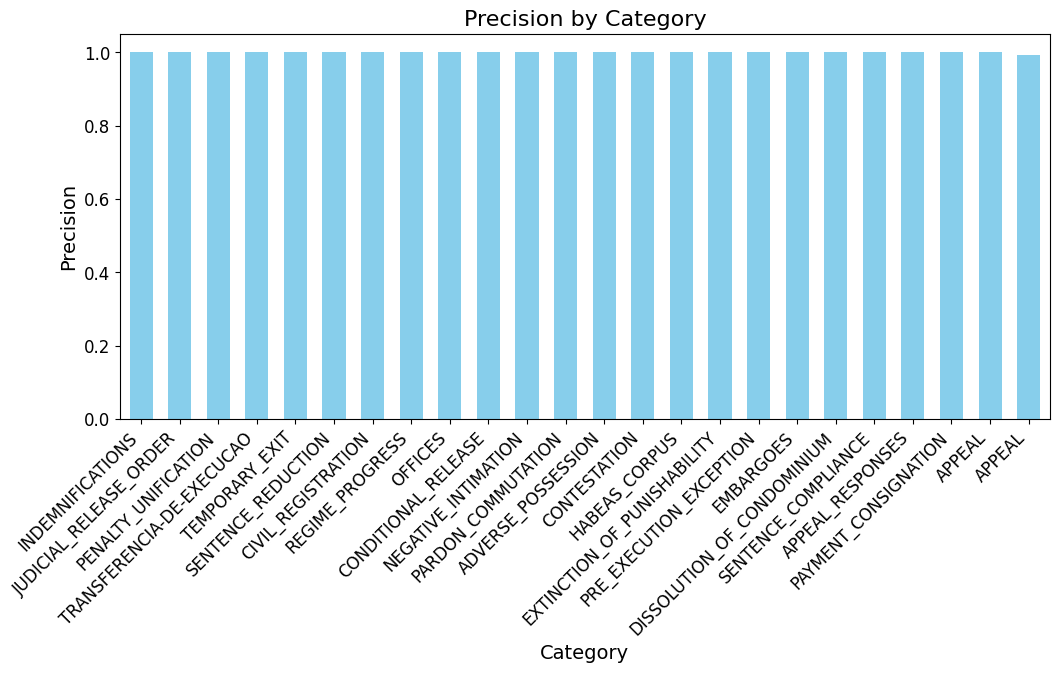

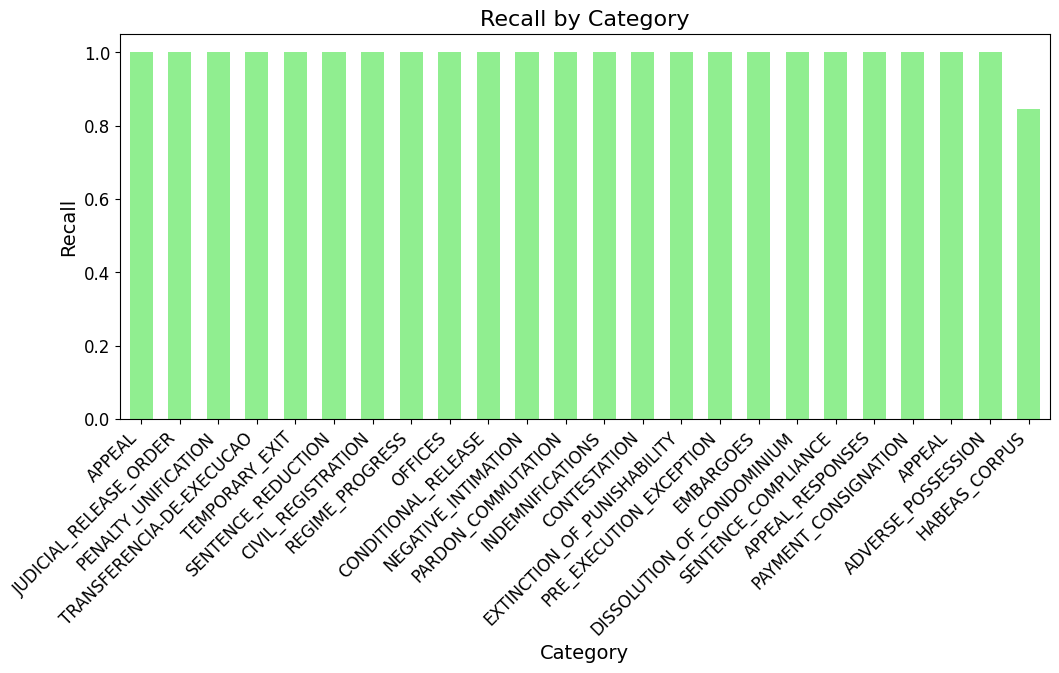

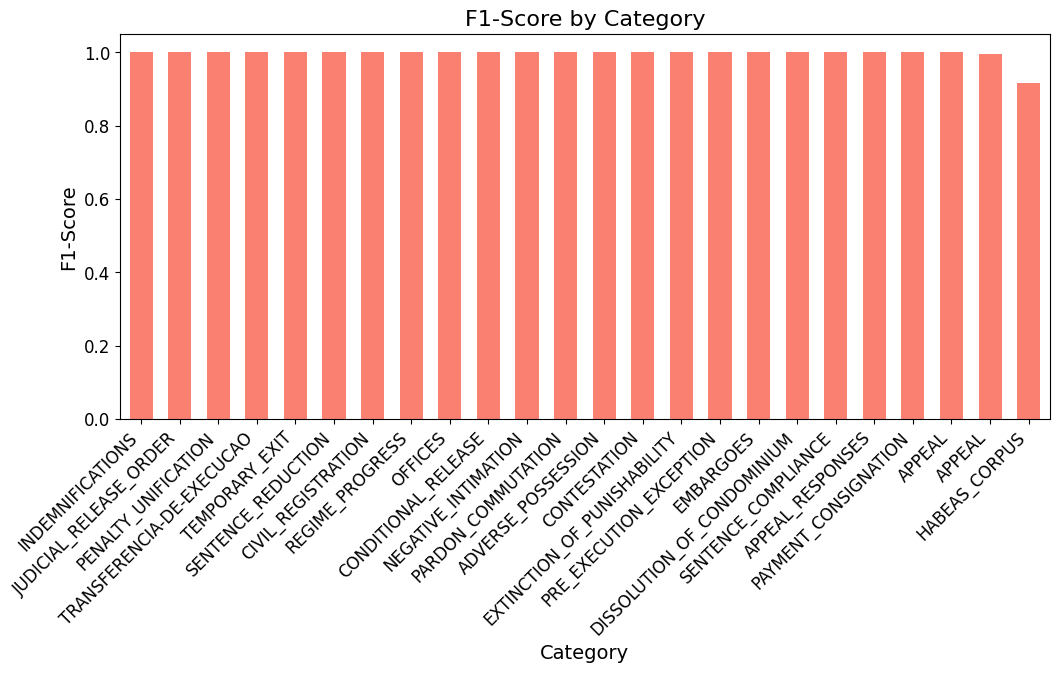

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Mapeamento das categorias para inglês
category_mapping = {
    "INTIMACAO-NEGATIVA": "NEGATIVE_INTIMATION",
    "AGRAVO": "APPEAL",
    "REGISTRO-CIVIL": "CIVIL_REGISTRATION",
    "INDENIZATORIAS": "INDEMNIFICATIONS",
    "IMPUGNACAO": "CONTESTATION",
    "EMBARGOS": "EMBARGOES",
    "EXTINCAO-DE-PUNIBILIDADE": "EXTINCTION_OF_PUNISHABILITY",
    "OFICIOS": "OFFICES",
    "LIVRAMENTO-CONDICIONAL": "CONDITIONAL_RELEASE",
    "APELACAO": "APPEAL",
    "DISSOLUCAO-DE-CONDOMINIO": "DISSOLUTION_OF_CONDOMINIUM",
    "CUMPRIMENTO-DE-SETENCA": "SENTENCE_COMPLIANCE",
    "HABEAS-CORPUS": "HABEAS_CORPUS",
    "REMICAO-DE-PENA": "SENTENCE_REDUCTION",
    "UNIFICACAO-DE-PENAS": "PENALTY_UNIFICATION",
    "INDULTO-COMUTACAO": "PARDON_COMMUTATION",
    "PROGRESSAO-DE-REGIME": "REGIME_PROGRESS",
    "EXCECAO-DE-PRE-EXECUTIVIDADE": "PRE_EXECUTION_EXCEPTION",
    "TRANFERENCIA-DE-EXECUCAO": "EXECUTION_TRANSFER",
    "USUCAPIAO": "ADVERSE_POSSESSION",
    "SAIDA-TEMPORARIA": "TEMPORARY_EXIT",
    "ALVARA-JUDICIAL-LIBERACAO-DE-CORPO": "JUDICIAL_RELEASE_ORDER",
    "CONSIGNACAO-EM-PAGAMENTO": "PAYMENT_CONSIGNATION",
    "CONTRARRAZOES-AO-AGRAVO": "APPEAL_RESPONSES"
}

# Calcular o relatório de classificação
report_dict = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Remover categorias com resultados zero e médias indesejadas
df_report = df_report[(df_report['precision'] > 0) | (df_report['recall'] > 0) | (df_report['f1-score'] > 0)]
df_report = df_report.drop(['accuracy', 'macro avg', 'weighted avg', 'micro avg'], errors='ignore')

# Ajustar a largura das barras
bar_width = 0.6

# Substituir os nomes das categorias pelas suas versões em inglês
df_report.index = [category_mapping.get(category, category) for category in df_report.index]

# Ordenar os valores para visualização pela precisão
df_report_precision = df_report.sort_values(by='precision', ascending=False)

# Precisão
plt.figure(figsize=(12, 5))
df_report_precision['precision'].plot(kind='bar', color='skyblue', width=bar_width)
plt.title('Precision by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Ordenar os valores para visualização pelo recall
df_report_recall = df_report.sort_values(by='recall', ascending=False)

# Recall
plt.figure(figsize=(12, 5))
df_report_recall['recall'].plot(kind='bar', color='lightgreen', width=bar_width)
plt.title('Recall by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Ordenar os valores para visualização pelo f1-score
df_report_f1 = df_report.sort_values(by='f1-score', ascending=False)

# F1-Score
plt.figure(figsize=(12, 5))
df_report_f1['f1-score'].plot(kind='bar', color='salmon', width=bar_width)
plt.title('F1-Score by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

**Matriz de Confusão**

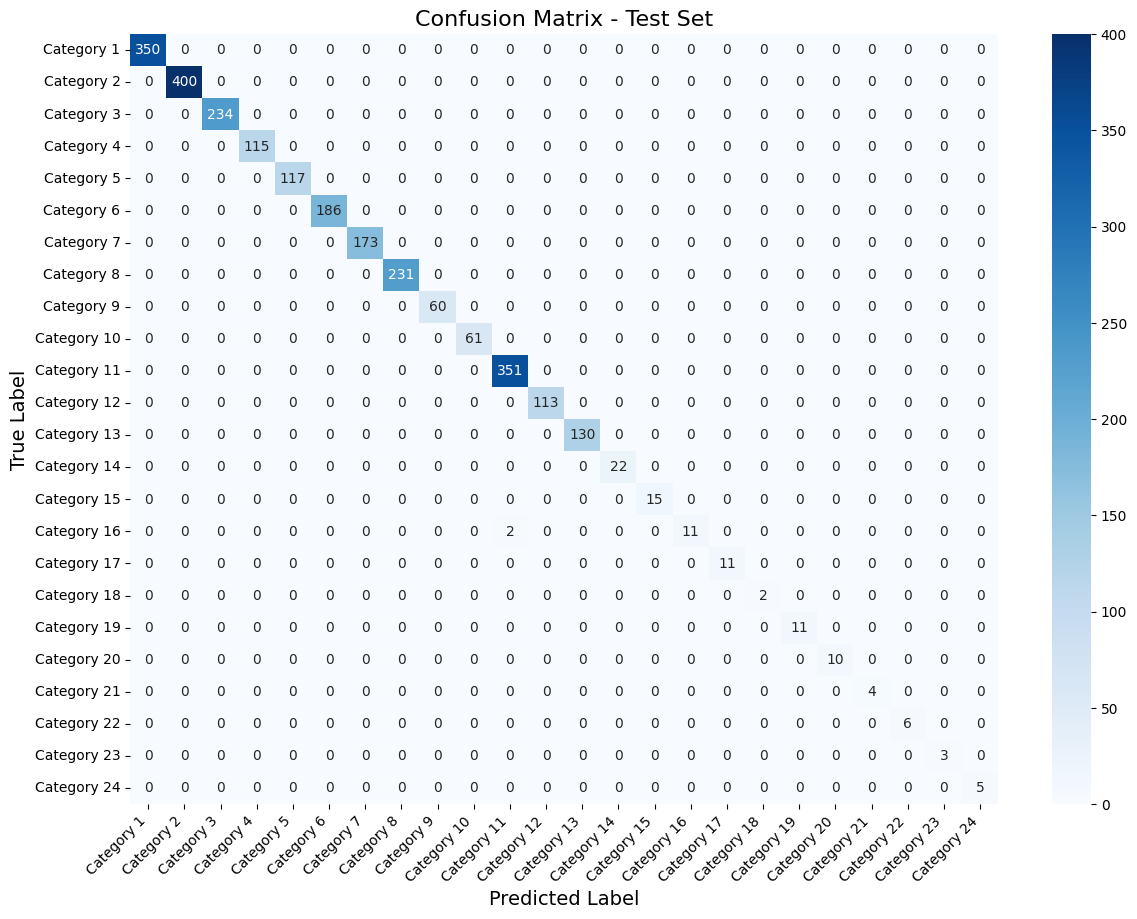

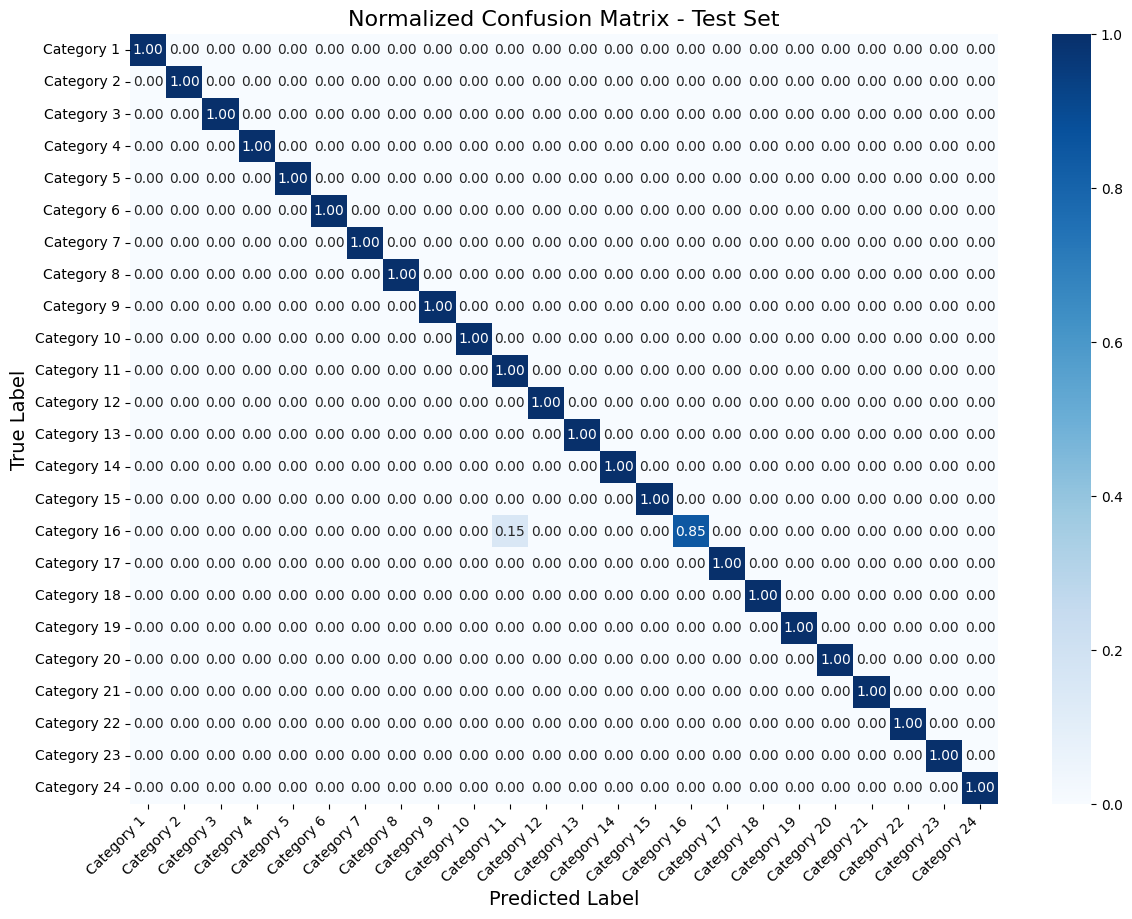

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# df_sample é o DataFrame contendo os rótulos verdadeiros e previstos
df_sample = pd.DataFrame({
    'issue_area': y_true,
    'resultados': y_pred
})

# Calcular a matriz de confusão
cm = confusion_matrix(df_sample['issue_area'], df_sample['resultados'], labels=df_sample['issue_area'].unique())

# Normalizar a matriz de confusão
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Criar rótulos numéricos para as categorias em inglês
categories = [f'Category {i+1}' for i in range(len(df_sample['issue_area'].unique()))]

# Criar DataFrames para as matrizes de confusão
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
df_cm_normalized = pd.DataFrame(cm_normalized, index=categories, columns=categories)

# Plotar a matriz de confusão normal
plt.figure(figsize=(14, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix - Test Set', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Plotar a matriz de confusão normalizada
plt.figure(figsize=(14, 10))
sns.heatmap(df_cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Normalized Confusion Matrix - Test Set', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()